In [1]:
import os
import pandas
import matplotlib.pyplot as plt
import matplotlib.image as img
import os
import seaborn as sns
# Set default Seaborn style
sns.set(style="darkgrid")
#from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression

In [2]:
import math

def roundup(x):
    return int(math.ceil(x / 10.0)) * 10

# This is still experimental

This notebook allows you to calculate the **ACM Hub Observability** sizing for fleet management based on your inputs as explained in __Critical Input Parameters to Size__ section

## Methodology of Calculation
1. Firstly we have to calculate how many time series do we need to persist. This is calculated in 2 steps.
    1. Step-1 : Calculated Number of time series for Base 3M+3W deployment for a Cluster (based on lab data)
    1. Step-2: Calcluated Number of Time series for Additional Worker Nodes
1. Then from total number of time series, we infer
    1. Memory requirement (2 hours of this time series data is stored in memory)
    1. CPU Requirement 
    1. Disk needed for PVs (volume of data stored is dictated by settings in MultiCluster Observability CR)
    1. Storage needed for Object store (volume of data stored is dictated by settings in MultiCluster Observability CR). This is has many simplifying assumptions.

_All calculations are in this notebook below - and they are easy to follow._

#### From Scale testing/Observation:
We have data of CPU, Memory usage of the ACM hub as more managed cluster join till all transients stabilize. [Raw data is available here](http://e27-h01-000-r650.rdu2.scalelab.redhat.com:8081/results/ACM-2.8/20230817-211625-int-ztp-300-500b-43200i-83/acm-inspector-data-2/).

In [3]:
fname = os.path.join("..","images","sizing_summary_based_on_max_run_08222023.csv")
master_df = pandas.read_csv(fname,index_col=0)
master_df.info()
master_df

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9 entries, 0 to 8
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   cluster-count         9 non-null      int64  
 1   etcdetcdDBSizeMB      9 non-null      float64
 2   KubeAPIMemUsageWSSGB  9 non-null      float64
 3   OtherMemUsageWSSGB    9 non-null      float64
 4   ACMObsMemUsageWSSGB   9 non-null      float64
 5   ACMOthMemUsageWSSGB   9 non-null      float64
 6   ClusterMemUsageGB     9 non-null      float64
 7   KubeAPICPUCoreUsage   9 non-null      float64
 8   OtherCPUCoreUsage     9 non-null      float64
 9   ACMObsCPUCoreUsage    9 non-null      float64
 10  ACMOthCPUCoreUsage    9 non-null      float64
 11  ClusterCPUCoreUsage   9 non-null      float64
 12  ClusterCPUUsage       9 non-null      float64
 13  TimeSeriesCount       9 non-null      float64
dtypes: float64(13), int64(1)
memory usage: 1.1 KB


,cluster-count,etcdetcdDBSizeMB,KubeAPIMemUsageWSSGB,OtherMemUsageWSSGB,ACMObsMemUsageWSSGB,ACMOthMemUsageWSSGB,ClusterMemUsageGB,KubeAPICPUCoreUsage,OtherCPUCoreUsage,ACMObsCPUCoreUsage,ACMOthCPUCoreUsage,ClusterCPUCoreUsage,ClusterCPUUsage,TimeSeriesCount
0,1,492.132812,15.842926,29.345032,2.224129,4.217648,98.014347,2.005463,4.955723,0.087176,1.062161,7.125632,7.125632,1.208533e+04
1,501,4765.730469,44.041397,71.184624,26.002499,12.360477,198.057091,27.162713,18.659946,6.976063,6.028077,51.071514,51.071514,1.774576e+06
2,1001,6968.148438,70.522301,85.191090,53.609005,21.798447,265.963261,41.666794,24.313306,10.258325,6.897012,78.659244,78.659244,3.704551e+06
3,1501,8657.406250,95.487778,100.638203,79.539074,27.120926,329.887955,29.254207,32.240631,14.904547,14.223816,84.916373,84.916373,5.483344e+06
4,2001,10417.035156,116.932346,117.019630,110.827610,33.914574,391.354710,38.871293,37.774763,23.447564,10.326685,104.121879,104.121879,7.229043e+06
5,2501,12133.246094,130.561272,132.690632,136.744621,39.276440,441.112297,46.194071,44.631129,24.730487,11.975998,116.910643,116.910643,9.022662e+06
6,3001,14056.968750,142.836929,147.665379,165.513916,44.791946,482.628525,44.892960,44.095892,31.291865,11.213243,126.479453,126.479453,1.081609e+07
7,3501,15887.367188,160.520748,163.741425,196.502529,52.538059,535.832123,44.998772,45.603580,36.887440,12.349075,130.973728,130.973728,1.261727e+07
8,3619,16190.859375,162.349144,184.511856,217.550026,53.207111,549.857502,43.223547,48.597584,37.383142,10.983012,117.938693,117.938693,1.306206e+07


## Interpret the Test Results being used as Ground Truth

### All managed clusters used in this testing was uniform. 
- They were all SNOs with same number of policies 

### Scatter plots confirm that the metrics are almost linearly related with managed cluster count.


Since relationships are linear, Therefore, let us calculate the Pearson's r with respect cluster-count


cluster-count           1.000000
etcdetcdDBSizeMB        0.990125
KubeAPIMemUsageWSSGB    0.989208
OtherMemUsageWSSGB      0.986999
ACMObsMemUsageWSSGB     0.997441
ACMOthMemUsageWSSGB     0.996972
ClusterMemUsageGB       0.992907
KubeAPICPUCoreUsage     0.791195
OtherCPUCoreUsage       0.958572
ACMObsCPUCoreUsage      0.996040
ACMOthCPUCoreUsage      0.752464
ClusterCPUCoreUsage     0.930581
ClusterCPUUsage         0.930581
TimeSeriesCount         0.999965
Name: cluster-count, dtype: float64

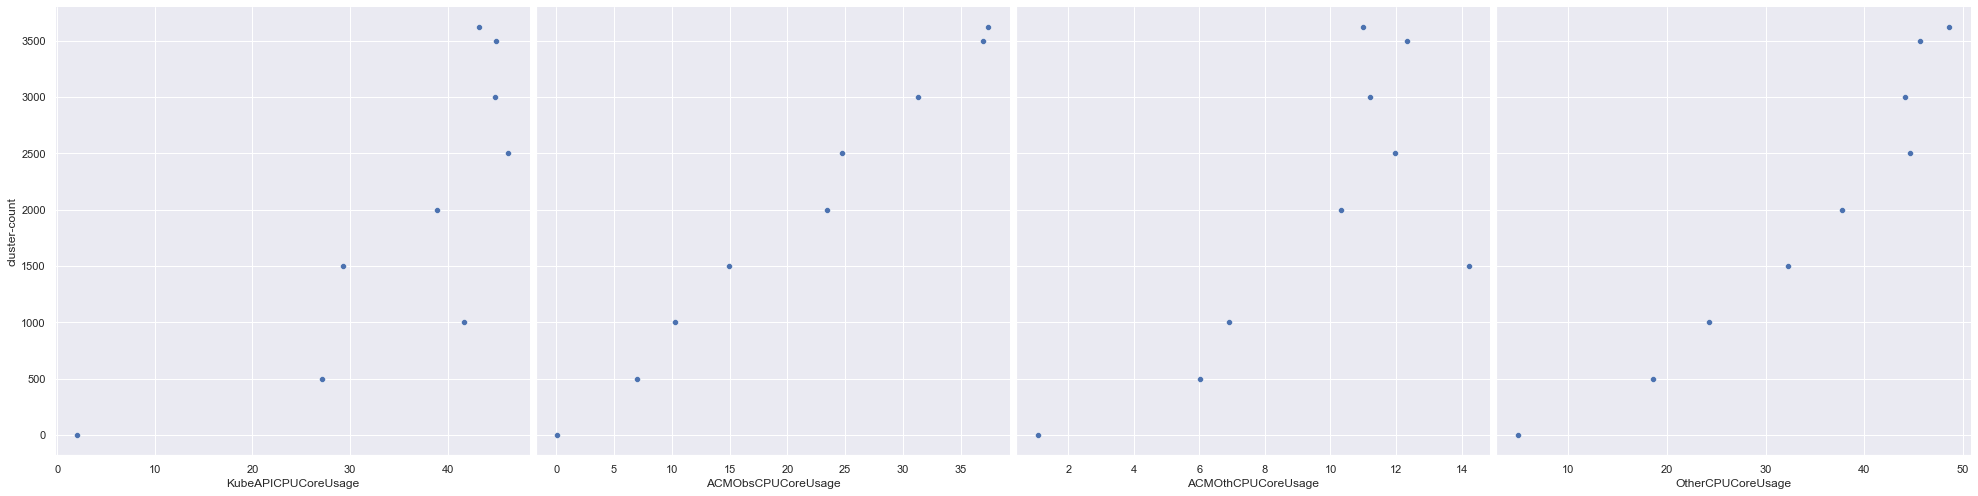

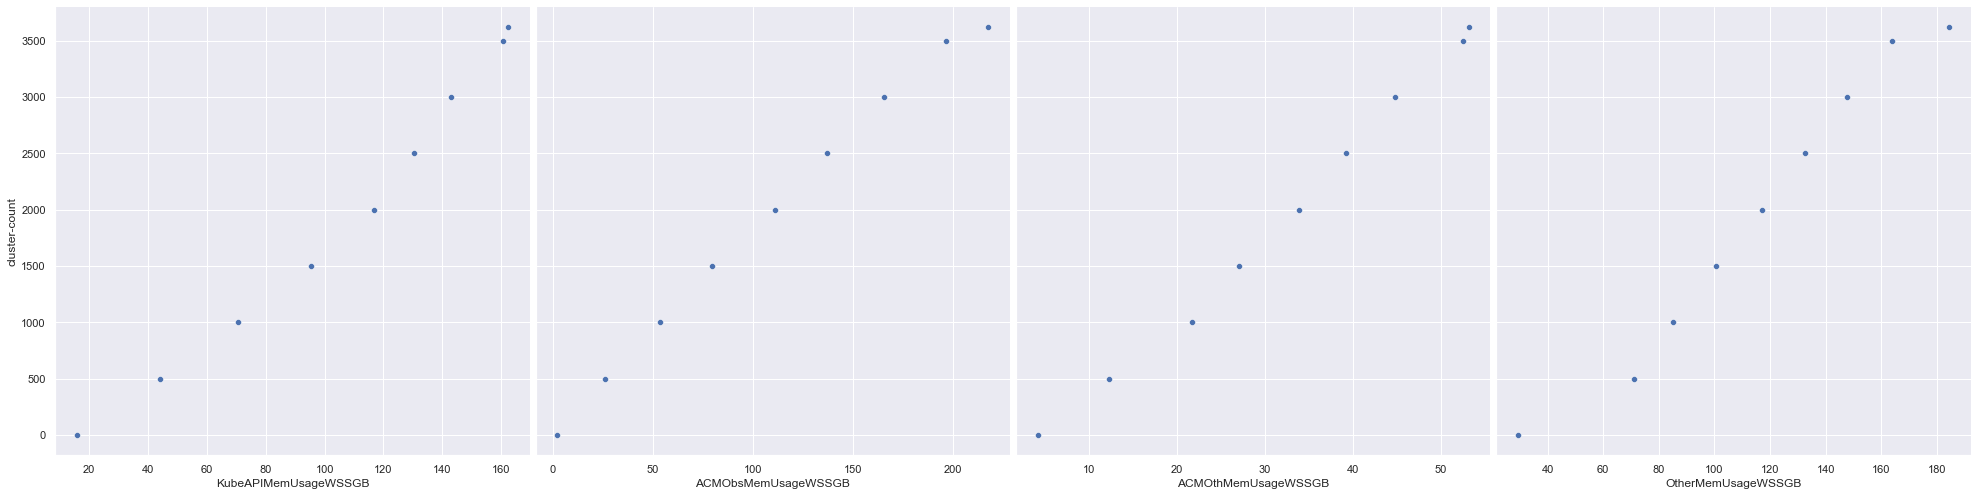

In [4]:
cp = sns.pairplot(master_df, x_vars=['KubeAPICPUCoreUsage','ACMObsCPUCoreUsage','ACMOthCPUCoreUsage','OtherCPUCoreUsage'], y_vars='cluster-count', height=7, aspect=1)
mp = sns.pairplot(master_df, x_vars=['KubeAPIMemUsageWSSGB','ACMObsMemUsageWSSGB','ACMOthMemUsageWSSGB','OtherMemUsageWSSGB'], y_vars='cluster-count', height=7, aspect=1)


print("Since relationships are linear, Therefore, let us calculate the Pearson's r with respect cluster-count")
master_df.corr()['cluster-count']

### Scatter plots confirm that the Observability metrics are almost linearly related with time series count.

Since relationships are linear, Therefore, let us calculate the Pearson's r with respect TimeSeriesCount


cluster-count           0.999965
etcdetcdDBSizeMB        0.990524
KubeAPIMemUsageWSSGB    0.989758
OtherMemUsageWSSGB      0.987241
ACMObsMemUsageWSSGB     0.997343
ACMOthMemUsageWSSGB     0.997402
ClusterMemUsageGB       0.993287
KubeAPICPUCoreUsage     0.792972
OtherCPUCoreUsage       0.959208
ACMObsCPUCoreUsage      0.995688
ACMOthCPUCoreUsage      0.754722
ClusterCPUCoreUsage     0.931622
ClusterCPUUsage         0.931622
TimeSeriesCount         1.000000
Name: TimeSeriesCount, dtype: float64

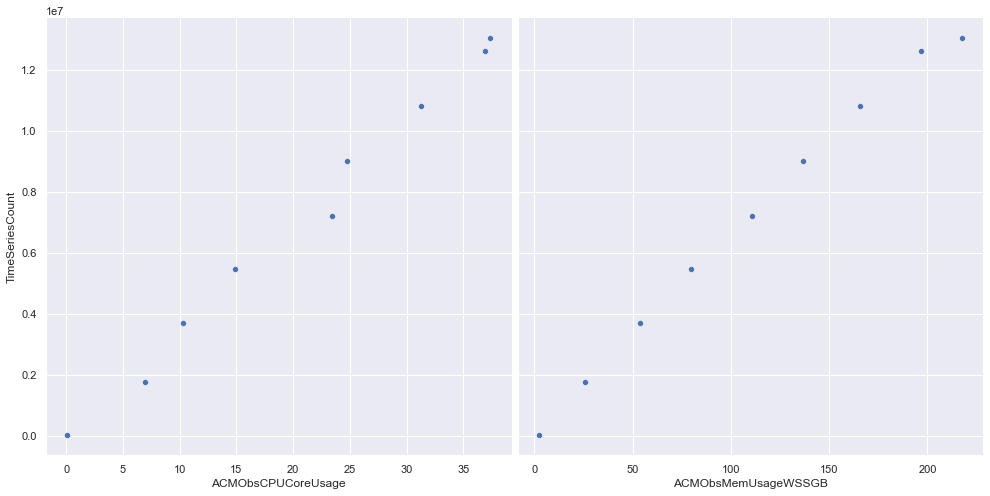

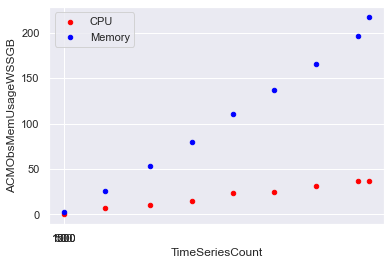

In [5]:
cp = sns.pairplot(master_df, x_vars=['ACMObsCPUCoreUsage','ACMObsMemUsageWSSGB'], y_vars='TimeSeriesCount', height=7, aspect=1)
#mp = sns.pairplot(master_df, x_vars=['ACMObsMemUsageWSSGB'], y_vars='TimeSeriesCount', height=7, aspect=1)

ax=master_df.plot.scatter(x='TimeSeriesCount', y='ACMObsCPUCoreUsage',label='CPU',s=20, c='red',xticks=[0,500,1000,1500])
master_df.plot.scatter(x='TimeSeriesCount', y='ACMObsMemUsageWSSGB',s=20,label='Memory', c='blue',ax=ax)



print("Since relationships are linear, Therefore, let us calculate the Pearson's r with respect TimeSeriesCount")
master_df.corr()['TimeSeriesCount']

### Conclusion - Timeseries Count is a strong predictor for Observability Sizing

### Internal data points  - do not touch!
These are based on recordings at the lab. These should not be tweaked by anyone except from ACM Observability team who are familiar with the background data.

In [6]:
#0.5 bytes - 1.5 bytes is maximum range. This is for storage in disk (not memory)
observed_bytes_for_storage_per_ts=2

### Critical Input Parameters to Size
>- **Please tweak these values as needed**
>- *Our calculations are solely based on what you input below*
>- *We can estimate the number of time series per cluster based on your inputs - which is one of the key parameters. However, if one of these clusters exist, it is stronly advisable to run this https://github.com/stolostron/multicluster-observability-operator/tree/main/tools/simulator/metrics-collector/metrics-extractor, get the number of time series for a representative cluster, and use the accompanying notebook **ObsSizingTemplateGivenTimeSeriesCount** to do the calculation.*


In [ ]:
number_of_managed_clusters=50

# Shape of each cluster
# Out of the box assumption is that a cluster typically has 3 Master and 3 Worker Nodes
# but if master_nodes is 1, it means all of our managed clusters are SNOs
number_of_master_node=3

# If the cluster has 50 worker nodes, change this number to 47
number_of_addn_worker_nodes=40

number_of_vcore_per_node=32
# This is number of pods per node.
number_of_application_pods_per_node=125
# This is the total number additional namespaces to be created on the cluster
number_of_ns=200
# This number cannot be tweaked yet. We just assume all pods will have one containers.
number_of_container_per_pod=1


#sampling interval - how frequently do we send data to ACM for storage
number_of_samples_per_hour=12
number_of_hours_pv_retention_hrs=24
number_of_days_for_storage=365

# default number of workers is 3 considering compact clusters as default
# but should be 1 when working with snos
number_of_default_worker_nodes=3
if number_of_master_node==1:
  number_of_default_worker_nodes=1

# Present Sizing for Object Store
input_data = {'Specs': ['Number of Managed Clusters',  
                        'Number of Master Nodes',
                        'Number of Worker Nodes',
                        'Total Number of Nodes',
                        'Number of virtual CPU Core per Node',
                        'Number of application pods per node',
                        'Total Number of Pods per cluster',
                        'Number of namespaces (excl Openshift ns)',
                        'Number of containers per pod',
                        'Number of metric samples per hour',
                        'Number of hours of retention in Receiver PV',
                        'Target days for storage of data assuming downsampling'], 
        'Value': [number_of_managed_clusters,
                  number_of_master_node,
                  number_of_addn_worker_nodes,
                  number_of_addn_worker_nodes+number_of_master_node,
                  number_of_vcore_per_node,
                  number_of_application_pods_per_node,
                  number_of_application_pods_per_node*(number_of_addn_worker_nodes+number_of_default_worker_nodes),
                  number_of_ns,
                  number_of_container_per_pod,
                  number_of_samples_per_hour,
                  number_of_hours_pv_retention_hrs,number_of_days_for_storage]
           } 
  
# Create DataFrame 
input_df = pandas.DataFrame(input_data) 
  
# Print the output. 
input_df

,Specs,Value
0,Number of Managed Clusters,50
1,Number of Master Nodes,3
2,Number of Worker Nodes,40
3,Total Number of Nodes,43
4,Number of virtual CPU Core per Node,32
5,Number of application pods per node,125
6,Total Number of Pods per cluster,5375
7,Number of namespaces (excl Openshift ns),200
8,Number of containers per pod,1
9,Number of metric samples per hour,12





### Calculated Number of time series for Base 3M+3W deployment for a Cluster
1. These are taken from our observations in the lab.
1. These will be updated from the lab data.
1. These should not be changed otherwise.

### Internal data points  - do not touch!
These are based on recordings at the lab

In [8]:
#observed_number_of_ts_per_cluster=453
#observed_number_of_addn_ts_per_cluster=1296
observed_number_of_ts_per_master_node=75
observed_number_of_ts_for_3m3w=7606
observed_number_of_ts_for_sno=3603


In [9]:
if number_of_master_node == 1:
# managed clusters as snos
   number_of_base_time_series_per_cluster=(
       observed_number_of_ts_for_sno
   )
   print("Number of Base time series per SNO cluster: ",number_of_base_time_series_per_cluster)
elif (number_of_addn_worker_nodes == 0) and (number_of_master_node == 3):
# managed clusters our standard 3M+3W
    number_of_base_time_series_per_cluster=(
        observed_number_of_ts_for_3m3w
    )
 
    print("Number of Base time series per 3M+3W cluster: ",number_of_base_time_series_per_cluster)
else:
    number_of_base_time_series_per_cluster=(
        observed_number_of_ts_for_3m3w-(3*observed_number_of_ts_per_master_node)+
        observed_number_of_ts_per_master_node*number_of_master_node
    )
 
    print("Number of Base time series for the cluster: ",number_of_base_time_series_per_cluster)


Number of Base time series per 3M+3W cluster:  7606


### Calcluated Number of Time series for Additional Worker Nodes
1. As outlined above, base cluster = 3 Master + 3 Workers
1. If there are additional Worker nodes - ie more than 3 workers - this section calculates the details of it.
1. And this section calculates impact of those additional worker nodes and artifacts created on it like namespace, pods etc.

#### Notes about the calculation
We know certain metrics create time series as a proportion of:
1. pod
1. node
1. namespace
1. number of virtual core per node

Therefore:
resultant time series for a metric = A-mulitplier * pod|node|namespace|number-of-virtual-core-per-node

That is factored in below.
```
pod_multiplier={
    ....
    "container_memory_cache":3,
    ....
    }
```    
This means that number of time series metric container_memory_cache will create = (3 * number-of-pods). __This is a very extensible model__. If we want to add a new metric, all we need to know is:
- is it influenced by pod|node|namespace|number-of-virtual-core-per-node
- if so, what is multiplier
- add it in the code

In [10]:
pod_multiplier={
    "kube_pod_info":1,
    "kube_pod_owner":1,
    "namespace_workload_pod:kube_pod_owner:relabel":1,
    "up":1,
    "node_namespace_pod_container:container_cpu_usage_seconds_total:sum_irate":1,
    "container_memory_rss:sum":1, 
    "container_memory_cache":3,
    "container_memory_rss":3,
    "container_memory_swap":3,
    "container_memory_working_set_bytes":3,
    "kube_pod_container_resource_limits":2,
    "kube_pod_container_resource_requests":2
    
}
node_multiplier={
    "instance:node_cpu_utilisation:rate1m":1,
    "instance:node_load1_per_cpu:ratio":1,
    "instance:node_memory_utilisation:ratio":1,
    "instance:node_network_receive_bytes_excluding_lo:rate1m":1,
    "instance:node_network_receive_drop_excluding_lo:rate1m":1,
    "instance:node_network_transmit_bytes_excluding_lo:rate1m":1,
    "instance:node_network_transmit_drop_excluding_lo:rate1m":1,
    "instance:node_num_cpu:sum":1,
    "instance:node_vmstat_pgmajfault:rate1m":1,
    "instance_device:node_disk_io_time_seconds:rate1m":1,
    "instance_device:node_disk_io_time_weighted_seconds:rate1m":1,
    "kube_node_spec_unschedulable":1,
    "machine_cpu_cores":1,
    "machine_memory_bytes":1,
    "node_netstat_TcpExt_TCPSynRetrans":1,
    "node_netstat_Tcp_OutSegs":1,
    "node_netstat_Tcp_RetransSegs":1,
    "node_memory_MemAvailable_bytes untyped":1,
    "kube_node_status_allocatable":7,
    "kube_node_status_capacity":7,
    "kube_node_status_condition":12,
    "node_filesystem_avail_bytes":8,
    "node_filesystem_free_bytes":8,
    "coredns_dns_request_duration_seconds_sum":1,
    "node_filesystem_size_bytes untyped":8
}
namespace_multiplier={
    "namespace:container_memory_usage_bytes:sum":1,
    "namespace_cpu:kube_pod_container_resource_requests:sum":1,
    "kube_pod_container_resource_limits:sum":2,
    "kube_pod_container_resource_requests:sum":2,
    "namespace_workload_pod:kube_pod_owner:relabel:avg":1,
    "node_namespace_pod_container:container_cpu_usage_seconds_total:sum":1,
    "container_memory_rss:sum":1,
}
vcore_per_node_multiplier={
    "node_cpu_seconds_total":8}

In [ ]:
number_of_ts_for_all_pod=0
number_of_ts_for_all_node=0
number_of_ts_for_all_ns=0
number_of_ts_for_all_vcore=0

#Pod multiplier
if number_of_master_node != 1:
  # if not an SNO, affected by workers multipliers
  for x in pod_multiplier.values():
    temp= (number_of_addn_worker_nodes+number_of_default_worker_nodes)*number_of_application_pods_per_node*x
    number_of_ts_for_all_pod=number_of_ts_for_all_pod+temp
  print("number_of_ts_for_all_pod: ",number_of_ts_for_all_pod)

#Node multiplier
  for x in node_multiplier.values():
    temp= number_of_addn_worker_nodes*x
    number_of_ts_for_all_node=number_of_ts_for_all_node+temp
  print("number_of_ts_for_all_node: ",number_of_ts_for_all_node)

#Namespace multiplier
  for x in namespace_multiplier.values():
    temp= number_of_ns*x
    number_of_ts_for_all_ns=number_of_ts_for_all_ns+temp
  print("number_of_ts_for_all_ns: ",number_of_ts_for_all_ns)

#vcore multiplier
  for x in vcore_per_node_multiplier.values():
    temp= number_of_addn_worker_nodes*number_of_vcore_per_node*x
    number_of_ts_for_all_vcore=number_of_ts_for_all_vcore+temp
  print("number_of_ts_for_all_vcore: ",number_of_ts_for_all_vcore)


number_of_addn_time_series_per_cluster=(
    number_of_ts_for_all_pod +
    number_of_ts_for_all_node +
    number_of_ts_for_all_ns +
    number_of_ts_for_all_vcore
)
print("=================================")
print("Additional number of time series due to extra worker nodes per cluster: ",number_of_addn_time_series_per_cluster)

number_of_ts_for_all_pod:  118250
number_of_ts_for_all_node:  2760
number_of_ts_for_all_ns:  1800
number_of_ts_for_all_vcore:  10240
Additional number of time series due to extra worker nodes per cluster:  133050


### Total Number of Time series for each cluster

In [12]:
number_of_time_series_per_cluster= number_of_base_time_series_per_cluster + number_of_addn_time_series_per_cluster
print("Number of Base time series per 3M+3W cluster: ",number_of_base_time_series_per_cluster)
print("Additional number of time series due to extra worker nodes per cluster: ",number_of_addn_time_series_per_cluster)
print("=======================================================================")
print("Total Number of Time series per cluster: ",number_of_time_series_per_cluster)

Number of Base time series per 3M+3W cluster:  7606
Additional number of time series due to extra worker nodes per cluster:  133050
Total Number of Time series per cluster:  140656


### Inferring Memory Requirement
*Thanos Receiver stores time series in memory for 2 hrs. This cannot be configured*
- Though there are lots of pods which are running, the main consumer of memory is the Thanos Receiver
- Therefore for large systems, basing SWAGs on Receiver memory is good enough cover for all Pods in the observability namespace
- Also this total memory figure does not change if replication count of receiver is changed.

In [13]:
print("Total Time Series count: ",number_of_managed_clusters*number_of_time_series_per_cluster)
print("------------------------------------")

X = master_df['TimeSeriesCount'].values.reshape(-1,1)
Y = master_df['ACMObsMemUsageWSSGB'].values.reshape(-1,1)

regressor = LinearRegression()  
#training the algorithm
regressor.fit(X,Y) 
#To retrieve the intercept:
alpha = regressor.intercept_
print(f'alpha = {alpha}')
#For retrieving the slope:
beta = regressor.coef_
print(f'beta = {beta}')

y_pred = alpha + beta*number_of_managed_clusters*number_of_time_series_per_cluster
print(f'A rough Predicted Memory need in GB for {number_of_managed_clusters*number_of_time_series_per_cluster} timeseries - IFF linearity holds = {y_pred} GB')

memory_data = {'Projected Memory (GB)': [y_pred], 
        'Note': ['This is good of linearity assumption holds']
           } 
  
memory_df = pandas.DataFrame(memory_data) 
memory_df

Total Time Series count:  7032800
------------------------------------
alpha = [-3.78028111]
beta = [[1.60469085e-05]]
A rough Predicted Memory need in GB for 7032800 timeseries - IFF linearity holds = [[109.07441665]] GB


,Projected Memory (GB),Note
0,[[109.07441665433858]],This is good of linearity assumption holds


### Inferring CPU requirement


In [14]:
print("Total Time Series count: ",number_of_managed_clusters*number_of_time_series_per_cluster)
print("------------------------------------")

X = master_df['TimeSeriesCount'].values.reshape(-1,1)
Y = master_df['ACMObsCPUCoreUsage'].values.reshape(-1,1)

regressor = LinearRegression()  
#training the algorithm
regressor.fit(X,Y) 
#To retrieve the intercept:
alpha = regressor.intercept_
print(f'alpha = {alpha}')
#For retrieving the slope:
beta = regressor.coef_
print(f'beta = {beta}')

y_pred = alpha + beta*number_of_managed_clusters*number_of_time_series_per_cluster
print(f'A rough Predicted CPU vCPU needed for {number_of_managed_clusters*number_of_time_series_per_cluster} timeseries - IFF linearity holds = {y_pred} vCPU')

cpu_data = {'Projected CPU  (vCPU)': [y_pred], 
        'Note': ['This is good of linearity assumption holds']
           } 
  
cpu_df = pandas.DataFrame(cpu_data) 
cpu_df

Total Time Series count:  7032800
------------------------------------
alpha = [0.56711376]
beta = [[2.83832114e-06]]
A rough Predicted CPU vCPU needed for 7032800 timeseries - IFF linearity holds = [[20.52845865]] vCPU


,Projected CPU (vCPU),Note
0,[[20.528458650495963]],This is good of linearity assumption holds


### Inferring PVC Requirement
*Thanos Receiver storage duration is controlled by customer as indicated above. So please make sure that the parameters is given correctly*

In [15]:
#actual_number_of_time_series_local_retention=(
#    actual_number_of_time_series_per_2h*(number_of_hours_pv_retention_hrs/2)
#)

actual_number_of_time_series_local_retention=(
number_of_samples_per_hour*
number_of_managed_clusters*
number_of_time_series_per_cluster*
number_of_hours_pv_retention_hrs
)
inferred_gb_storage_recv=(
    (actual_number_of_time_series_local_retention*observed_bytes_for_storage_per_ts)/(1024*1024*1024)
)

print("Number of hours of retention in Receiver PV: ", number_of_hours_pv_retention_hrs)
print("Assumed storage space per time series: ",observed_bytes_for_storage_per_ts, " bytes")

inferred_gb_storage_am=10
inferred_gb_storage_compactor=100
inferred_gb_storage_rule=30
inferred_gb_storage_store=100

# Present Sizing for PVC
pvc_data = {'Pod': ['alertmanager', 'thanos-receiver', 
                    'thanos-compactor', 'thanos-rule','thanos-store'], 
        'Number of Replicas': [3,3,1,3,3],
        'Sizes Per Replica (GB)': [roundup(inferred_gb_storage_am), 
                                   roundup(inferred_gb_storage_recv), 
                                   roundup(inferred_gb_storage_compactor), 
                                   roundup(inferred_gb_storage_rule),
                                   roundup(inferred_gb_storage_store)],
        'Total Size (GB)': [roundup(inferred_gb_storage_am)*3, 
                            roundup(inferred_gb_storage_recv)*3, 
                            roundup(inferred_gb_storage_compactor)*1, 
                            roundup(inferred_gb_storage_rule)*3,
                            roundup(inferred_gb_storage_store)*3]} 
  
# Create DataFrame 
pvc_df = pandas.DataFrame(pvc_data) 
  
# Print the output. 
pvc_df


Number of hours of retention in Receiver PV:  24
Assumed storage space per time series:  2  bytes


,Pod,Number of Replicas,Sizes Per Replica (GB),Total Size (GB)
0,alertmanager,3,10,30
1,thanos-receiver,3,10,30
2,thanos-compactor,1,100,100
3,thanos-rule,3,30,90
4,thanos-store,3,100,300


- The above calculation shows the expected Receiver PVC size per instance of a receiever. This is calculated using assumptions. The time series data is saved in TSDB on the PVC. It is retained for duration of local retention. It is hard to estimate the size without looking at the data. Commonly, its seen to be between 1~2 bytes per record. Here we assume it to be 2 bytes. This however does not take into account the WAL size. [Background material can be found here.](https://www.robustperception.io/how-much-disk-space-do-prometheus-blocks-use/)
- There are a few other PVCs needed (assuming replica of 3 where needed). We recommend the following sizes for these:
>```
alertmanager-db-observability-alertmanager-0 - 10GB
alertmanager-db-observability-alertmanager-1 - 10GB
alertmanager-db-observability-alertmanager-2 - 10GB
data-observability-thanos-compact-0 - 100GB 
data-observability-thanos-receive-default-0 - calculated above
data-observability-thanos-receive-default-1 - calculated above
data-observability-thanos-receive-default-2 - calculated above
data-observability-thanos-rule-0 - 30GB (could be lesser, but it is hard to estimate at this stage)       
data-observability-thanos-rule-1 - 30GB (could be lesser, but it is hard to estimate at this stage)     
data-observability-thanos-rule-2 - 30GB (could be lesser, but it is hard to estimate at this stage)  
data-observability-thanos-store-shard-0-0 - 100 GB 
data-observability-thanos-store-shard-1-0 - 100 GB 
data-observability-thanos-store-shard-2-0 - 100 GB 
```
- Compact [data-observability-thanos-compact-0] PVC needs increasing storage as the duration of data stored grows. Conceptually, as duration grows, it has to bring over proportional amount of that data to compact. It is spiked utilization. It uses this space during compaction and then the usage drops back to 0. As per [Thanos documentation](https://thanos.io/tip/components/compact.md/#disk/) ```The compactor needs local disk space to store intermediate data for its processing as well as bucket state cache. Generally, for medium sized bucket about 100GB should be enough to keep working as the compacted time ranges grow over time. However, this highly depends on size of the blocks. In worst case scenario compactor has to have space adequate to 2 times 2 weeks (if your maximum compaction level is 2 weeks) worth of smaller blocks to perform compaction. First, to download all of those source blocks, second to build on disk output of 2 week block composed of those smaller ones.```
- Store-shard [data-observability-thanos-store-shard-*-*] PVC: As per [Thanos documentation](https://thanos.io/tip/components/store.md/) ```It acts primarily as an API gateway and therefore does not need significant amounts of local disk space. It joins a Thanos cluster on startup and advertises the data it can access. It keeps a small amount of information about all remote blocks on local disk and keeps it in sync with the bucket. This data is generally safe to delete across restarts at the cost of increased startup times.```. This PV may go away in future versions of ACM.

### Inferring Object Store Requirement
*The data retention and downsampling settings in the MCO CR affect these. We make some simplifying assumptions here and do the calculation based on max number of data the data needs to be stored.*

In [16]:
#this is needed just in case the number_of_hours_pv_retention_hrs is set to something other than 24hrs
inferred_obj_storage_per_day=inferred_gb_storage_recv*24/number_of_hours_pv_retention_hrs
inferred_obj_storage_for_life=inferred_obj_storage_per_day*number_of_days_for_storage*3

print("Target days for storage of data assuming downsampling: ", number_of_days_for_storage)
print("Inferred Object Storage needed: ", inferred_obj_storage_for_life , "GB")

# Present Sizing for Object Store
obj_data = {'Steps': ['Raw storage for 1 day (GB)', 
                      'number of days to be stored', 
                      'Raw storage for all days (GB)', 
                      '5m storage for all days (GB)',
                      '1hr storage for all days (GB)',
                      'Total storage for all days (GB)'], 
        'Value': [inferred_obj_storage_per_day,
                  number_of_days_for_storage,
                  inferred_obj_storage_for_life/3,
                  inferred_obj_storage_for_life/3,
                  inferred_obj_storage_for_life/3,
                  roundup(inferred_obj_storage_for_life)]
           } 
  
# Create DataFrame 
objstore_df = pandas.DataFrame(obj_data) 
  
# Print the output. 
objstore_df


Target days for storage of data assuming downsampling:  365
Inferred Object Storage needed:  4131.093263626099 GB


,Steps,Value
0,Raw storage for 1 day (GB),3.772688
1,number of days to be stored,365.000000
2,Raw storage for all days (GB),1377.031088
3,5m storage for all days (GB),1377.031088
4,1hr storage for all days (GB),1377.031088
5,Total storage for all days (GB),4140.000000


Lets look at the simplifying assumptions. You may have set:
>- raw data to be stored for 14 days
>- 5m interval data to be stored for 3 months
>- 1hour interval data to be stored for 12 months

We simplify the above to:
- 12 months aka 365 days of storage
- and since we have 3 raw and 5m and 1hr interval needed to be stored, we multiply by 3
- and we also assuming the data storage size be appx 2 bytes per time series

[Background material can be found here.](https://thanos.io/tip/thanos/design.md/#cost)


## Final Recommendation

In [17]:
#print("*****************************************")
#print("******* Inputs to the System ************")
#print("*****************************************")
#print("Number of Managed Clusters: ",number_of_managed_clusters)
#print("Each Managed cluster is assumed to have: ", (number_of_addn_worker_nodes+3), "Worker nodes")

#print("Each worker node is assumed to have: ", number_of_vcore_per_node, "Virutal cores")
#print("Total Number of Pods per cluster: ", number_of_application_pods_per_node*(number_of_addn_worker_nodes+3))
#print("Total Number of additional namespaces created per cluster: ", number_of_ns)

#print("Number of time series per cluster: ",number_of_time_series_per_cluster)
#print("Number of metric samples per hour: ",number_of_samples_per_hour)
#print("Number of hours of retention in Receiver PV: ", number_of_hours_pv_retention_hrs)
#print("Target days for storage of data assuming downsampling: ", number_of_days_for_storage)
#print("")
#print("")

print("**********************************************************************************")
print("******** High Level Estimates for sizing of ACM Hub Observability  ***************")
#print("********************************************************************************")
print("** These are based on utilization numbers seen during Lab testing.")
print("** Lab Testing included collecting metrics and alerts across the managed clusters")
print("** and out of the box rule analysis.")
print("** These are provided as inputs to customer capacity planning needs.")
print("**********************************************************************************")
print("")
#print("*****************************************")
print("******* Inputs to the System ************")
print("----------------------------------------------------------------------")
print(input_df.to_markdown())
print("")
print("")
print("******* Derived ************")
print("----------------------------------------------------------------------")
print("Number of time series per cluster: ",number_of_time_series_per_cluster)
print("")
print("")
#print("*****************************************")
print("******* Recommendations ************")
#print("*****************************************")
print("----------------------------------------------------------------------")
print("Memory and CPU Inferred Value for HA Configuration")
print("==> this is sum of resources all pods in observability namspace")
print("----------------------------------------------------------------------------")
print("")
print(memory_df.to_markdown())
print(cpu_df.to_markdown())
print("")
print("")
print("Storage Inferred Value for Persistent Volume (Block storage) for all replicas:")
print("----------------------------------------------------------------------------------------------")
print(pvc_df.to_markdown())
print("")
print("Storage Inferred Value for Object Store:")
print("----------------------------------------------------")
print(objstore_df.to_markdown())

**********************************************************************************
******** High Level Estimates for sizing of ACM Hub Observability  ***************
** These are based on utilization numbers seen during Lab testing.
** Lab Testing included collecting metrics and alerts across the managed clusters
** and out of the box rule analysis.
** These are provided as inputs to customer capacity planning needs.
**********************************************************************************

******* Inputs to the System ************
----------------------------------------------------------------------
|    | Specs                                                 |   Value |
|---:|:------------------------------------------------------|--------:|
|  0 | Number of Managed Clusters                            |      50 |
|  1 | Number of Master Nodes                                |       3 |
|  2 | Number of Worker Nodes                                |      40 |
|  3 | Total Numb